In [616]:
import warnings
import calendar

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from business_models import greenplum
from business_models.greenplum import GreenplumManager
from business_models import hahn

In [617]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

In [618]:
bov_sql = '''
    use hahn;
    PRAGMA yt.Pool = 'taxi-delivery';

    $parse = DateTime::Parse("%Y-%m-%d");

    $business_overview = '//home/taxi-delivery/production/bizdev/bov/business_overview';

    select country_group, client_tariff, executor_tariff, dt,
     sum(gmv_lcy*currency_rate_lcy_to_rub) as gmv,
        sum(net_inflow_lcy*currency_rate_lcy_to_rub) as net_inflow_lcy,
        sum(deliveries) as deliveries
    from $business_overview as b
    where DateTime::MakeDate(DateTime::StartOfMonth(msk_finished_dt)) >= DateTime::MakeDate($parse('2023-01-01'))

    group by country_group, client_tariff, executor_tariff, DateTime::MakeDate(DateTime::StartOfMonth(msk_finished_dt)) as dt
    ;
'''

In [619]:
bov_df = hahn(bov_sql)

In [620]:
bov_df

,country_group,client_tariff,executor_tariff,dt,gmv,net_inflow_lcy,deliveries
0,International,sdd,ndd,2023-05-01,1.190569e+02,1.000478e+02,1.0
1,International,other,courier,2023-07-01,2.113267e+03,1.825328e+03,9.0
2,International,cargo,cargo,2023-05-01,1.851715e+06,-9.851291e+05,2136.0
3,International,sdd,courier,2023-05-01,1.388383e+05,-2.898730e+04,31185.0
4,,sdd,no executor,2023-06-01,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...
558,International,sdd,express,2023-09-01,6.485890e+05,-4.021309e+05,1063.0
559,International,cargo,cargo,2023-07-01,3.472739e+06,-8.579243e+05,3229.0
560,,empty,no executor,2023-06-01,NaN,NaN,0.0
561,International,courier,courier,2023-07-01,1.925938e+08,-4.433276e+07,685069.0


In [621]:
bov_df.columns

Index(['country_group', 'client_tariff', 'executor_tariff', 'dt', 'gmv',
       'net_inflow_lcy', 'deliveries'],
      dtype='object')

In [622]:
bov_financial_ru = bov_df[bov_df['country_group']=='Russia'].groupby(['client_tariff', 'dt']).sum().reset_index()

In [623]:
bov_financial_ru2 = bov_df[bov_df['country_group']=='Russia'].groupby(['executor_tariff', 'dt']).sum().reset_index()

In [624]:
bov_data_df = bov_df[(
    (bov_df['country_group']=='Russia')&(bov_df['executor_tariff'].isin(
        ['cargo', 'express'])))|(bov_df['country_group']=='CIS')]

In [625]:
bov_data_df['stream'] = bov_data_df.apply(
    lambda x: x.country_group if x.country_group=='CIS' else x.executor_tariff, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [626]:
bov_agg = bov_data_df.groupby(['stream', 'dt'])['net_inflow_lcy', 'gmv'].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [627]:
bov_agg.columns = ['stream', 'mnth', 'ni', 'gmv']

In [628]:
for c in ['ni', 'gmv']:
    bov_agg[c] = bov_agg[c] / 1000000
    bov_agg[c] = bov_agg[c].astype(int)

In [635]:
bov_agg = bov_agg[bov_agg['mnth'].apply(lambda x: str(x) != '2023-10-01')]

In [700]:
bov_agg.pivot(index='mnth', columns='stream', values='ni')

stream,CIS,cargo,express
mnth,,,
2023-01-01,5,79,129
2023-02-01,20,92,189
2023-03-01,56,125,254
2023-04-01,65,141,246
2023-05-01,63,187,238
2023-06-01,74,203,234
2023-07-01,78,209,220
2023-08-01,110,254,258
2023-09-01,109,240,468


In [702]:
bov_agg.pivot(index='mnth', columns='stream', values='gmv')

stream,CIS,cargo,express
mnth,,,
2023-01-01,662,594,1110
2023-02-01,734,678,1442
2023-03-01,977,872,1881
2023-04-01,1007,961,1733
2023-05-01,1062,1081,1826
2023-06-01,1197,1179,1937
2023-07-01,1365,1237,1942
2023-08-01,1521,1417,2096
2023-09-01,1527,1419,3157


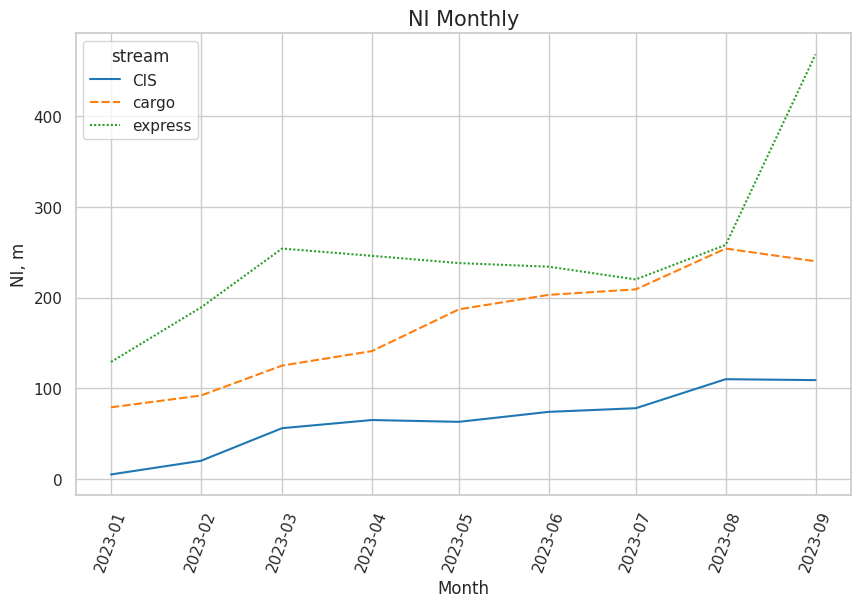

In [636]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=bov_agg.pivot(index='mnth', columns='stream', values='ni'))
plt.xticks(rotation=70)



ax.set(xlabel="Month", ylabel="NI, m")
ax.set_title('NI Monthly', fontsize=15)
ax.figure.set_size_inches(10, 6)

plt.show()

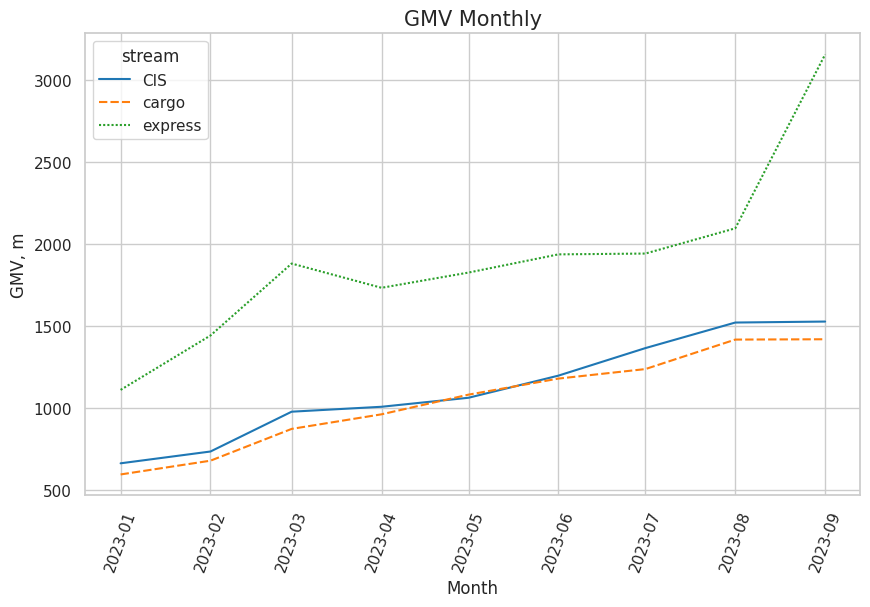

In [637]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=bov_agg.pivot(index='mnth', columns='stream', values='gmv'))
plt.xticks(rotation=70)



ax.set(xlabel="Month", ylabel="GMV, m")
ax.set_title('GMV Monthly', fontsize=15)
ax.figure.set_size_inches(10, 6)

plt.show()

In [177]:
goodbad = pd.read_csv('65072f67f90c9d6192fe1c90.csv')
goodbad_2 = pd.read_csv('65085e34e4444535b4bfb14d.csv')

In [182]:
goodbad.columns = [c.replace('average', 'regular') for c in goodbad.columns]

In [190]:
goodbad_2.columns = ['agglomeration', 'good_coriers', 'regular_coriers', 'good_mph_before', 'good_mph_after',
       'good_util_before', 'good_util_after', 'regular_mph_before',
       'regular_mph_after', 'regular_util_before', 'regular_util_after']

In [191]:
goodbad

,agglomeration,good_mph_before,good_mph_after,good_util_before,good_util_after,regular_mph_before,regular_mph_after,regular_util_before,regular_util_after
0,Krasnodar,650.410982,683.214642,0.686826,0.735008,581.011115,565.047210,0.603241,0.578427
1,Nizhny Novgorod,616.012078,637.983535,0.604680,0.637272,591.002212,576.146653,0.571029,0.555782
2,Novosibirsk,682.076029,715.478913,0.696564,0.723793,656.781896,639.754991,0.669274,0.650113
3,Rostov-on-Don,675.039745,695.363767,0.717756,0.752489,644.423795,629.682646,0.672712,0.651263


In [192]:
goodbad_2

,agglomeration,good_coriers,regular_coriers,good_mph_before,good_mph_after,good_util_before,good_util_after,regular_mph_before,regular_mph_after,regular_util_before,regular_util_after
0,Krasnodar,438,1153,670.536326,683.214642,0.669929,0.735008,658.554400,565.047210,0.621341,0.578427
1,Nizhny Novgorod,173,494,612.784835,637.983535,0.544540,0.637272,624.417730,576.146653,0.562387,0.555782
2,Novosibirsk,356,848,644.282017,715.478913,0.636490,0.723793,649.082456,639.754991,0.642875,0.650113
3,Rostov-on-Don,245,602,715.543079,695.363767,0.719561,0.752489,694.388613,629.682646,0.699708,0.651263


In [82]:
good = goodbad[['agglomeration', 'good_mph_before', 'good_mph_after', 'good_util_before', 'good_util_after']]
bad = goodbad[['agglomeration', 'regular_mph_before', 'regular_mph_after', 'regular_util_before', 'regular_util_after']]

good.columns = [c.replace('good_', '') for c in good.columns]
bad.columns = [c.replace('regular_', '') for c in bad.columns]

good['type'] = 'good'
bad['type'] = 'regular'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
good

,agglomeration,mph_before,mph_after,util_before,util_after,type
0,Krasnodar,650.410982,683.214642,0.686826,0.735008,good
1,Nizhny Novgorod,616.012078,637.983535,0.604680,0.637272,good
2,Novosibirsk,682.076029,715.478913,0.696564,0.723793,good
3,Rostov-on-Don,675.039745,695.363767,0.717756,0.752489,good


In [84]:
bad

,agglomeration,mph_before,mph_after,util_before,util_after,type
0,Krasnodar,581.011115,565.047210,0.603241,0.578427,regular
1,Nizhny Novgorod,591.002212,576.146653,0.571029,0.555782,regular
2,Novosibirsk,656.781896,639.754991,0.669274,0.650113,regular
3,Rostov-on-Don,644.423795,629.682646,0.672712,0.651263,regular


In [99]:
gb_df = pd.concat([good, bad])
gb_df = gb_df.reset_index(drop=True)

In [100]:
gb_df

,agglomeration,mph_before,mph_after,util_before,util_after,type
0,Krasnodar,650.410982,683.214642,0.686826,0.735008,good
1,Nizhny Novgorod,616.012078,637.983535,0.604680,0.637272,good
2,Novosibirsk,682.076029,715.478913,0.696564,0.723793,good
3,Rostov-on-Don,675.039745,695.363767,0.717756,0.752489,good
4,Krasnodar,581.011115,565.047210,0.603241,0.578427,regular
5,Nizhny Novgorod,591.002212,576.146653,0.571029,0.555782,regular
6,Novosibirsk,656.781896,639.754991,0.669274,0.650113,regular
7,Rostov-on-Don,644.423795,629.682646,0.672712,0.651263,regular


In [101]:
gb_df.columns

Index(['agglomeration', 'mph_before', 'mph_after', 'util_before', 'util_after',
       'type'],
      dtype='object')

In [163]:
df_diff_mph = pd.DataFrame()

for a in gb_df.agglomeration.unique():
    i_df = gb_df[gb_df['agglomeration']==a][['agglomeration', 'type', 'mph_before', 'mph_after']]
    
    for c in i_df[i_df.columns[2:]]:
        i_df[c] = i_df[c].astype(int)

    i_agg = i_df.agglomeration.tolist()[0]
    b_diff = (i_df[i_df['type']=='good'].mph_before.squeeze() - i_df[i_df['type']=='regular'].mph_before.squeeze()) / i_df[i_df['type']=='regular'].mph_before.squeeze()
    a_diff = (i_df[i_df['type']=='good'].mph_after.squeeze() - i_df[i_df['type']=='regular'].mph_after.squeeze()) / i_df[i_df['type']=='regular'].mph_after.squeeze()

    i_df['diff_before_after'] = (i_df['mph_after'] - i_df['mph_before']) / i_df['mph_before']

    i_df.loc[10] = np.array([a, 'diff_type', round(b_diff, 3), round(a_diff, 3), ''])
    
#     print(i_df)

    df_diff_mph = df_diff_mph.append(i_df, ignore_index=True)
    
df_diff_mph = df_diff_mph.reset_index(drop=True)

In [164]:
df_diff_mph

,agglomeration,type,mph_before,mph_after,diff_before_after
0,Krasnodar,good,650,683,0.050769
1,Krasnodar,regular,581,565,-0.027539
2,Krasnodar,diff_type,0.119,0.209,
3,Nizhny Novgorod,good,616,637,0.034091
4,Nizhny Novgorod,regular,591,576,-0.025381
5,Nizhny Novgorod,diff_type,0.042,0.106,
6,Novosibirsk,good,682,715,0.048387
7,Novosibirsk,regular,656,639,-0.025915
8,Novosibirsk,diff_type,0.04,0.119,
9,Rostov-on-Don,good,675,695,0.02963


In [175]:
df_diff_util = pd.DataFrame()

for a in gb_df.agglomeration.unique():
    i_df = gb_df[gb_df['agglomeration']==a][['agglomeration', 'type', 'util_before', 'util_after']]
    
    for c in i_df[i_df.columns[2:]]:
        i_df[c] = i_df[c].apply(lambda x: round(x, 3))
#         i_df[c] = i_df[c].astype(int)

    

    i_agg = i_df.agglomeration.tolist()[0]
    b_diff = (i_df[i_df['type']=='good'].util_before.squeeze() - i_df[i_df['type']=='regular'].util_before.squeeze()) / i_df[i_df['type']=='regular'].util_before.squeeze()
    a_diff = (i_df[i_df['type']=='good'].util_after.squeeze() - i_df[i_df['type']=='regular'].util_after.squeeze()) / i_df[i_df['type']=='regular'].util_after.squeeze()

    i_df['diff_before_after'] = round((i_df['util_after'] - i_df['util_before']) / i_df['util_before'], 3)

    i_df.loc[10] = np.array([a, 'diff_type', round(b_diff, 3), round(a_diff, 3), ''])
    
#     print(i_df)

    df_diff_util = df_diff_util.append(i_df, ignore_index=True)
    
df_diff_util = df_diff_util.reset_index(drop=True)

In [176]:
df_diff_util

,agglomeration,type,util_before,util_after,diff_before_after
0,Krasnodar,good,0.687,0.735,0.07
1,Krasnodar,regular,0.603,0.578,-0.041
2,Krasnodar,diff_type,0.139,0.272,
3,Nizhny Novgorod,good,0.605,0.637,0.053
4,Nizhny Novgorod,regular,0.571,0.556,-0.026
5,Nizhny Novgorod,diff_type,0.06,0.146,
6,Novosibirsk,good,0.697,0.724,0.039
7,Novosibirsk,regular,0.669,0.65,-0.028
8,Novosibirsk,diff_type,0.042,0.114,
9,Rostov-on-Don,good,0.718,0.752,0.047


In [194]:
goodbad_2.columns

Index(['agglomeration', 'good_coriers', 'regular_coriers', 'good_mph_before',
       'good_mph_after', 'good_util_before', 'good_util_after',
       'regular_mph_before', 'regular_mph_after', 'regular_util_before',
       'regular_util_after'],
      dtype='object')

In [213]:
g_df = goodbad_2[goodbad_2['agglomeration']=='Krasnodar'][['agglomeration', 'good_coriers','good_mph_before','good_mph_after', 'good_util_before', 'good_util_after']]

b_df = goodbad_2[goodbad_2['agglomeration']=='Krasnodar'][['agglomeration', 'regular_coriers','regular_mph_before', 'regular_mph_after', 'regular_util_before',
       'regular_util_after']]

g_df['type'] = 'good'
b_df['type'] = 'regular'

g_df.columns = ['agglomeration', 'coriers', 'mph_before', 'mph_after', 'util_before', 'util_after', 'type']
b_df.columns = ['agglomeration', 'coriers', 'mph_before', 'mph_after', 'util_before', 'util_after', 'type']

ttl_df = pd.concat([g_df, b_df])
ttl_df = ttl_df.reset_index(drop=True)

ttl_df = ttl_df[['agglomeration', 'type', 'coriers', 'mph_before', 'mph_after', 'util_before',
       'util_after']]

In [214]:
ttl_df

,agglomeration,type,coriers,mph_before,mph_after,util_before,util_after
0,Krasnodar,good,438,670.536326,683.214642,0.669929,0.735008
1,Krasnodar,regular,1153,658.554400,565.047210,0.621341,0.578427


In [266]:
mph_krd = ttl_df[['agglomeration', 'type', 'mph_before', 'mph_after']].melt(id_vars=['agglomeration', 'type'])
mph_krd.columns = ['agglomeration', 'courier_type', 'period', 'mph']
mph_krd['period'] = [i.replace('mph_', '') for i in mph_krd['period']]

In [267]:
mph_krd

,agglomeration,courier_type,period,mph
0,Krasnodar,good,before,670.536326
1,Krasnodar,regular,before,658.554400
2,Krasnodar,good,after,683.214642
3,Krasnodar,regular,after,565.047210


In [268]:
util_krd = ttl_df[['agglomeration', 'type', 'util_before', 'util_after']].melt(id_vars=['agglomeration', 'type'])
util_krd.columns = ['agglomeration', 'courier_type', 'period', 'util']
util_krd['period'] = [i.replace('util_', '') for i in util_krd['period']]

In [269]:
util_krd

,agglomeration,courier_type,period,util
0,Krasnodar,good,before,0.669929
1,Krasnodar,regular,before,0.621341
2,Krasnodar,good,after,0.735008
3,Krasnodar,regular,after,0.578427


In [289]:
1-0.025

0.975

In [281]:
mph_krd

,agglomeration,courier_type,period,mph
0,Krasnodar,good,before,670.536326
1,Krasnodar,regular,before,658.554400
2,Krasnodar,good,after,683.214642
3,Krasnodar,regular,after,565.047210


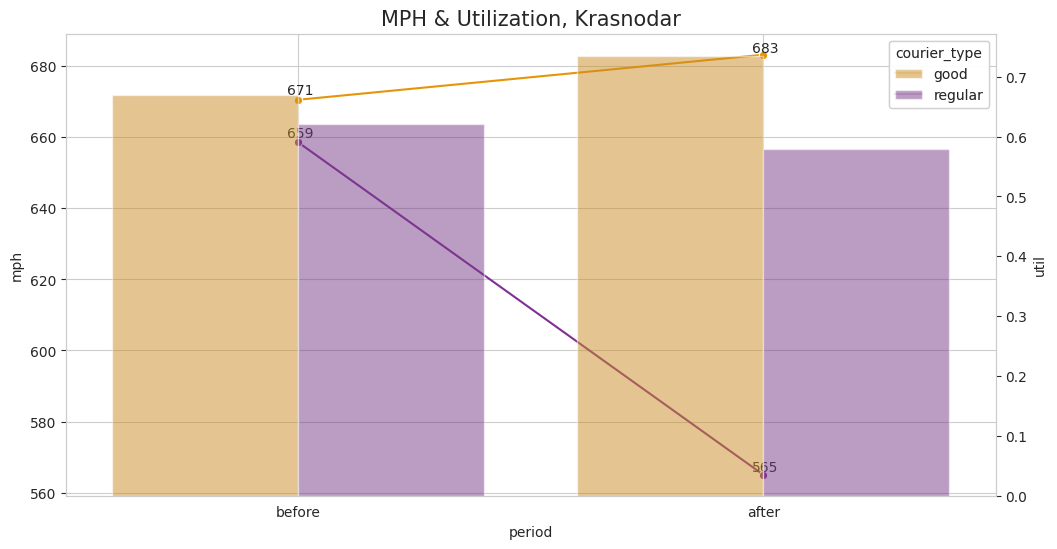

In [320]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=mph_krd, x='period', y='mph', hue='courier_type', sort = False, ax=ax1, palette='CMRmap_r', marker='o')

ax1.text(-0.025, 672, "671")
ax1.text(-0.025, 660, "659")
ax1.text(0.975, 684, "683")
ax1.text(0.975, 566, "565")

ax2 = ax1.twinx()

sns.barplot(x='period', y='util', data=util_krd, hue='courier_type', alpha=0.5, ax=ax2, palette='CMRmap_r')

ax2.grid(False)

ax1.set_title('MPH & Utilization, Krasnodar', fontsize=15)

plt.show()

In [661]:
mph_krd_new = pd.DataFrame({'agglomeration': {0: 'Krasnodar',
  1: 'Krasnodar',
  2: 'Krasnodar',
  3: 'Krasnodar'},
 'courier_type': {0: 'good', 1: 'regular', 2: 'good', 3: 'regular'},
 'period': {0: 'before', 1: 'before', 2: 'after', 3: 'after'},
 'mph': {0: 685,
  1: 657,
  2: 763,
  3: 545}})

util_krd_new = pd.DataFrame({'agglomeration': {0: 'Krasnodar',
  1: 'Krasnodar',
  2: 'Krasnodar',
  3: 'Krasnodar'},
 'courier_type': {0: 'good', 1: 'regular', 2: 'good', 3: 'regular'},
 'period': {0: 'before', 1: 'before', 2: 'after', 3: 'after'},
 'util': {0: 0.661,
  1: 0.610,
  2: 0.758,
  3: 0.524}})

In [662]:
mph_krd_new

,agglomeration,courier_type,period,mph
0,Krasnodar,good,before,685
1,Krasnodar,regular,before,657
2,Krasnodar,good,after,763
3,Krasnodar,regular,after,545


In [663]:
util_krd_new

,agglomeration,courier_type,period,util
0,Krasnodar,good,before,0.661
1,Krasnodar,regular,before,0.610
2,Krasnodar,good,after,0.758
3,Krasnodar,regular,after,0.524


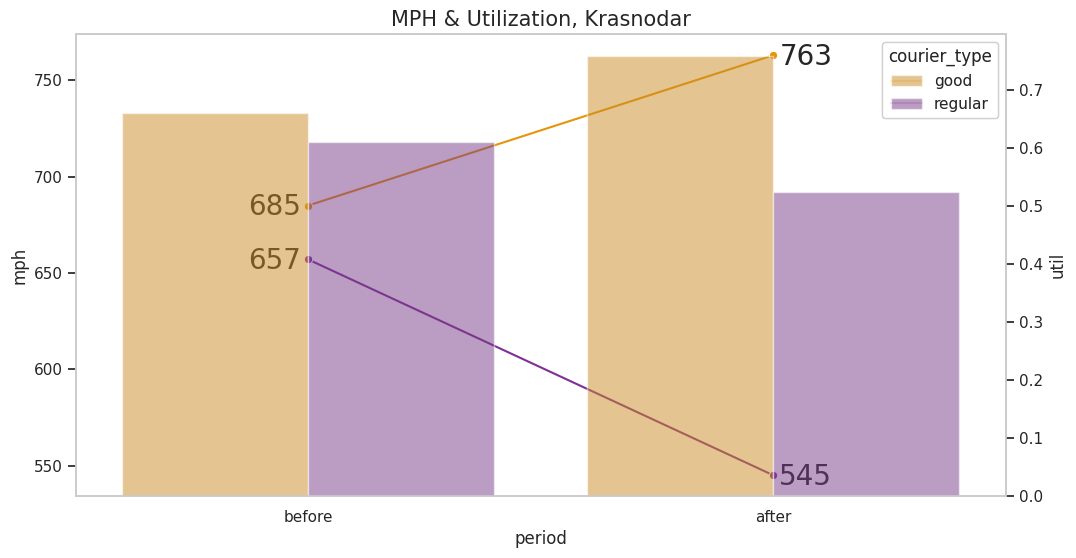

In [691]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=mph_krd_new, x='period', y='mph', hue='courier_type', sort = False, ax=ax1, palette='CMRmap_r', marker='o')

ax1.text(-0.13, 680, "685", fontsize=20)
ax1.text(-0.13, 652, "657", fontsize=20)
ax1.text(1.013, 758, "763", fontsize=20)
ax1.text(1.013, 540, "545", fontsize=20)

# ax1.text(-0.13, 680, "685", fontsize=20, rotation=70)

ax2 = ax1.twinx()

sns.barplot(x='period', y='util', data=util_krd_new, hue='courier_type', alpha=0.5, ax=ax2, palette='CMRmap_r')

ax1.grid(False)
ax2.grid(False)

ax1.set_title('MPH & Utilization, Krasnodar', fontsize=15)

plt.show()

In [417]:
drivers_frequency_sql = '''
use hahn;

$sept_active_drivers = '//home/taxi-delivery/analytics/ghostrider/working/sept_active_drivers_mph';

select *
from $sept_active_drivers
;
'''

In [418]:
drivers_frequency = hahn(drivers_frequency_sql)

In [426]:
dels_avg = drivers_frequency.groupby('distinct_days')['deliveries'].mean().reset_index()

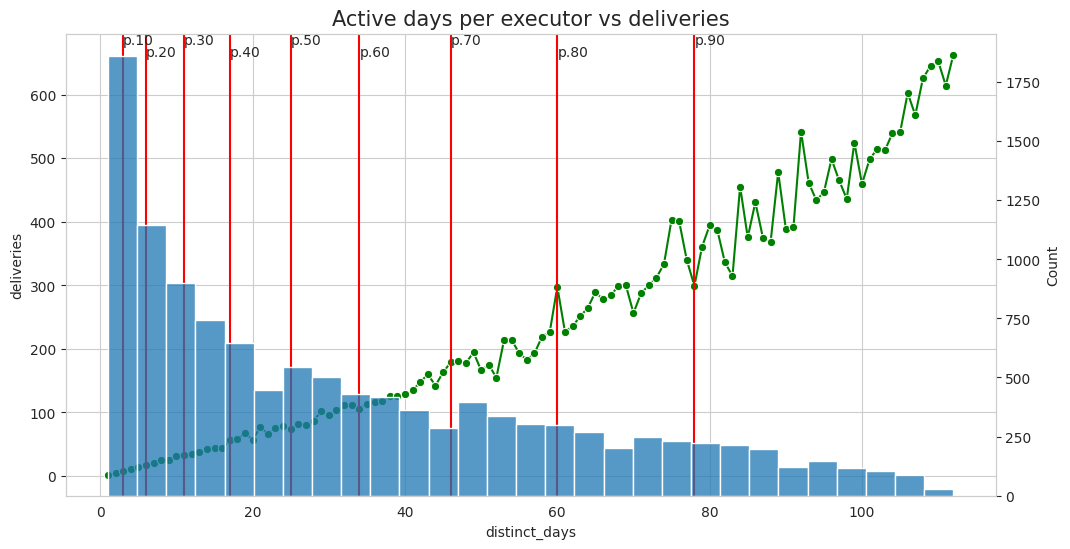

In [428]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=dels_avg, x='distinct_days', y='deliveries', sort = False, ax=ax1, marker='o', color='green')

ax2 = ax1.twinx()

sns.histplot(drivers_frequency['distinct_days'])

ax2.grid(False)

ax1.set_title('Active days per executor vs deliveries', fontsize=15)

for i in range(1,10):
    i_q = drivers_frequency.distinct_days.quantile(i*0.1)
    if i%2 == 0:
        height = 660
    else:
        height = 680
        
    ax1.axvline(i_q, color = "red")
    ax1.text(i_q, height, f'p.{i*10}')

plt.show()

In [439]:
{round(i*0.1, 2):drivers_frequency.distinct_days.quantile(i*0.1) for i in range(1,10)}

{0.1: 3.0,
 0.2: 6.0,
 0.3: 11.0,
 0.4: 17.0,
 0.5: 25.0,
 0.6: 34.0,
 0.7: 46.0,
 0.8: 60.0,
 0.9: 78.0}

In [451]:
def categorizer(x):
    if x >= 78:
        return '0.9'
    if x >= 60.0:
        return '0.8'
    if x >= 46.0:
        return '0.7'
    if x >= 34.0:
        return '0.6'
    if x >= 25.0:
        return '0.5'
    if x >= 17.0:
        return '0.4'
    if x >= 11.0:
        return '0.3'
    if x >= 6.0:
        return '0.2'
    if x >= 3.0:
        return '0.1'
    else:
        return '0.0'

In [454]:
drivers_frequency['distinct_days_bucket'] = drivers_frequency['distinct_days'].apply(categorizer)

In [455]:
drivers_frequency

,deliveries,distinct_days,driver_net_inflow,effective_sh,executor_profile_id,is_fulltimer,mph,taximeter_park_id,total_sh,utilization,dbid_uuid,distinct_days_bucket
0,17,8,2062.82208,2.369444,74dbfa1e53d7fd0fb5b7c1cfa95a1173,0,596.334979,d60bb197c2eb4d19bb4c1f08dcd3aea6,3.459167,0.684976,d60bb197c2eb4d19bb4c1f08dcd3aea6_74dbfa1e53d7f...,0.2
1,10,7,1090.15000,1.258611,716ce9b3f5fa4f95b82b87d53d764f3f,0,382.061916,5206fcd893904fa092171a3e7bc8cfec,2.853333,0.441102,5206fcd893904fa092171a3e7bc8cfec_716ce9b3f5fa4...,0.2
2,6,1,7154.47684,10.371111,44b221042e6a497aa9e893a2e67ef584,0,587.931808,480dd7124eef4257bb2c648473cbaf36,12.168889,0.852264,480dd7124eef4257bb2c648473cbaf36_44b221042e6a4...,0.0
3,1,1,1047.23520,0.840833,f2ddcb125e524cfd97b57d1a1bc704bd,0,188.417548,cd3d31d43e784877904155e030ea453d,5.558056,0.151282,cd3d31d43e784877904155e030ea453d_f2ddcb125e524...,0.0
4,3,1,0.00000,2.578056,1a33e33de83045d895a8185b4ef89420,0,0.000000,fdfa5c13f65d46ee9c16c70f4695b77e,2.922500,0.882140,fdfa5c13f65d46ee9c16c70f4695b77e_1a33e33de8304...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11796,301,81,6384.36000,6.112222,da3690783edd42e6b3cf4ee2bb1d27c6,1,588.736802,21134b6b98e04a6dafd90e98d9d13c83,10.844167,0.563641,21134b6b98e04a6dafd90e98d9d13c83_da3690783edd4...,0.9
11797,203,73,53075.38228,52.803333,11be1964008e427f9a325c6f8a9a9305,1,561.395078,f66bebe3b5184a2c841991f2fe3f00aa,94.541944,0.558518,f66bebe3b5184a2c841991f2fe3f00aa_11be1964008e4...,0.8
11798,322,84,22244.36452,22.179722,25d935b992ec46a784fccebe02c8d7c2,1,525.178299,695bf6f6a7fb46b888bb69ce114a605d,42.355833,0.523652,695bf6f6a7fb46b888bb69ce114a605d_25d935b992ec4...,0.9
11799,206,61,76788.50220,58.935278,8fd8fb5cac45461c9d9c577601bf2bfb,1,1034.668563,6a757d94fd354135a2b779db8b8ef411,74.215556,0.794110,6a757d94fd354135a2b779db8b8ef411_8fd8fb5cac454...,0.8


,distinct_days_bucket,driver_net_inflow,effective_sh,total_sh,deliveries,dbid_uuid
0,0.0,4.649033e+06,4786.252222,10380.934444,3538,1112
1,0.1,1.307389e+07,12930.465000,25230.233611,11418,1098
2,0.2,2.717602e+07,27288.193889,49270.722500,29678,1275
3,0.3,3.720022e+07,37512.517778,66170.877778,45163,1167
4,0.4,4.681366e+07,47387.073611,81954.507500,82769,1245
5,0.5,4.469983e+07,44424.665833,78302.493889,102508,1099
6,0.6,5.103426e+07,50305.448333,88920.281111,157357,1207
7,0.7,5.776187e+07,56325.001389,98866.683611,227878,1202
8,0.8,6.556168e+07,65418.917500,110747.964444,342016,1161
9,0.9,9.914191e+07,96374.665278,163991.641667,535916,1235


In [609]:
df_agg_mph = drivers_frequency.groupby('distinct_days_bucket').agg({
    'driver_net_inflow':'sum', 'effective_sh':'sum', 'total_sh':'sum',
    'deliveries':'sum', 'dbid_uuid':'nunique',
    'offer_seen':'sum', 'offer_accepted':'sum'}).reset_index()

df_agg_mph['deliveries_share'] = round(df_agg_mph['deliveries'] / df_agg_mph['deliveries'].sum(), 2)
df_agg_mph['mph'] = df_agg_mph['driver_net_inflow'] / df_agg_mph['total_sh']
df_agg_mph['util'] = df_agg_mph['effective_sh'] / df_agg_mph['total_sh']
df_agg_mph['ar'] = df_agg_mph['offer_accepted'] / df_agg_mph['offer_seen']

In [610]:
df_agg_mph[['distinct_days_bucket', 'dbid_uuid', 'deliveries_share', 'mph', 'util', 'ar']]

,distinct_days_bucket,dbid_uuid,deliveries_share,mph,util,ar
0,0.0,1112,0.00,447.843396,0.461062,0.660896
1,0.1,1098,0.01,518.183386,0.512499,0.684303
2,0.2,1275,0.02,551.565239,0.553842,0.685893
3,0.3,1167,0.03,562.184107,0.566904,0.691622
4,0.4,1245,0.05,571.215135,0.578212,0.650547
5,0.5,1099,0.07,570.860935,0.567347,0.645737
6,0.6,1207,0.10,573.932789,0.565736,0.609201
7,0.7,1202,0.15,584.239963,0.569707,0.616524
8,0.8,1161,0.22,591.989916,0.590701,0.597512
9,0.9,1235,0.35,604.554669,0.587680,0.594413


In [531]:
for _,b in df_agg_mph.iterrows():
    print(float(b.distinct_days_bucket)*10, 0.48, b.dbid_uuid)

0.0 0.48 1112
1.0 0.48 1098
2.0 0.48 1275
3.0 0.48 1167
4.0 0.48 1245
5.0 0.48 1099
6.0 0.48 1207
7.0 0.48 1202
8.0 0.48 1161
9.0 0.48 1235


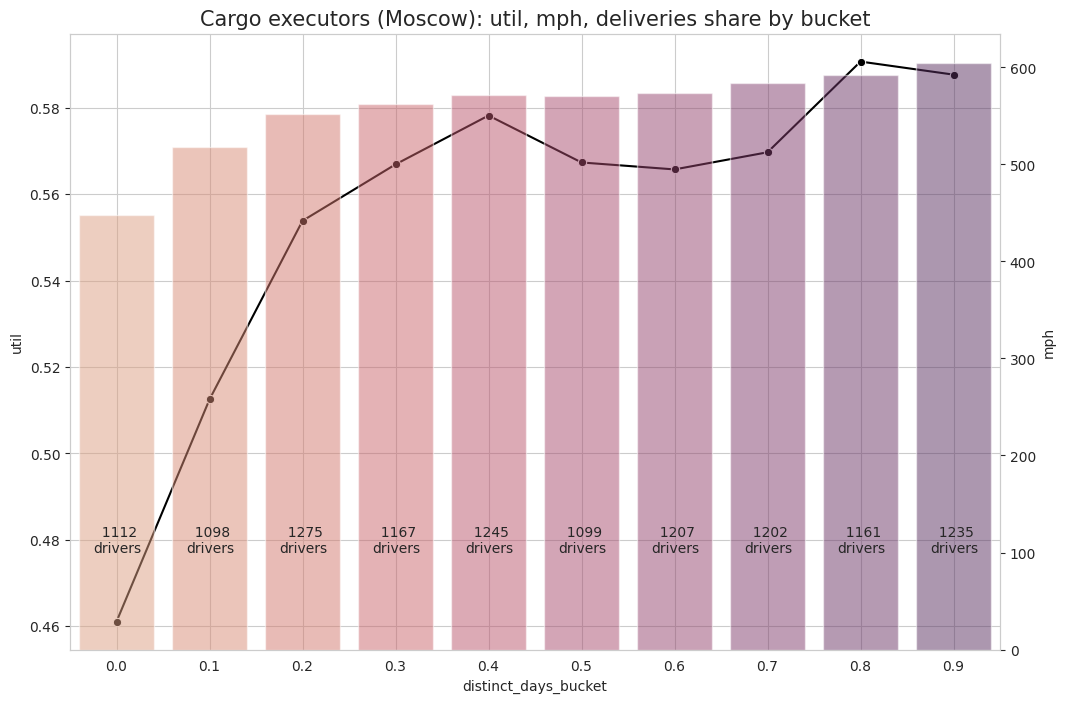

In [543]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,8))

sns.lineplot(data=df_agg_mph, x='distinct_days_bucket', y='util', sort = False, ax=ax1, marker='o', color='black')

ax2 = ax1.twinx()

sns.barplot(x='distinct_days_bucket', y='mph', data=df_agg_mph, alpha=0.5, ax=ax2, palette='flare')

ax2.grid(False)

for _,b in df_agg_mph.iterrows():
    ax2.text(float(b.distinct_days_bucket)*10-0.25, 100, f'  {b.dbid_uuid}\ndrivers')
# ax1.text(2, 0.48, 1235)

ax1.set_title('Cargo executors (Moscow): util, mph, deliveries share by bucket', fontsize=15)

plt.show()

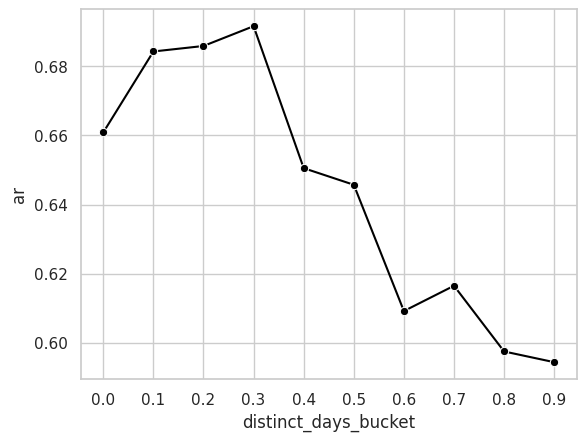

In [613]:
sns.lineplot(data=df_agg_mph, x='distinct_days_bucket', y='ar', sort = False, marker='o', color='black')
plt.show()

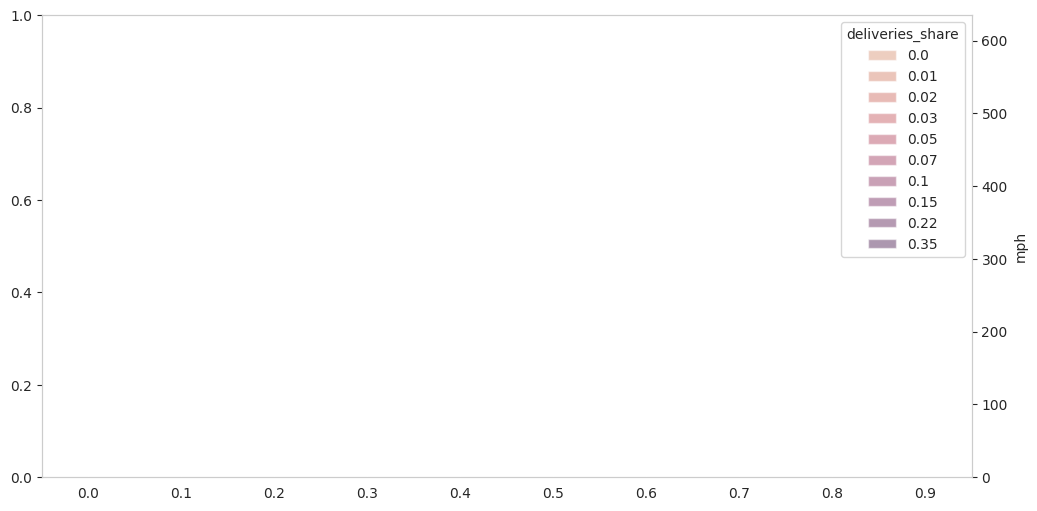

In [494]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.grid(False)
#sns.lineplot(data=df_agg_mph, x='distinct_days_bucket', y='util', sort = False, ax=ax1, marker='o')

ax2 = ax1.twinx()

sns.barplot(x='distinct_days_bucket', y='mph', data=df_agg_mph, alpha=0.5, ax=ax2, 
            hue='deliveries_share', palette='flare', width=0.001)

ax2.grid(False)

# ax1.set_title('MPH & Utilization, Krasnodar', fontsize=15)

plt.show()

In [498]:
#на треть выше утиль и мпх

In [559]:
bov_financial_ru.columns

Index(['client_tariff', 'dt', 'gmv', 'net_inflow_lcy', 'deliveries'], dtype='object')

In [643]:
bov_financial_ru['avg_fare'] = bov_financial_ru['gmv'] / bov_financial_ru['deliveries']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [639]:
bov_financial_ru = bov_financial_ru[bov_financial_ru['dt'].apply(lambda x: str(x) != '2023-10-01')]

In [644]:
bov_financial_ru

,client_tariff,dt,gmv,net_inflow_lcy,deliveries,avg_fare
0,cargo,2023-01-01,5.948558e+08,7.979638e+07,480575.0,1237.800209
1,cargo,2023-02-01,6.781512e+08,9.229911e+07,530239.0,1278.953911
2,cargo,2023-03-01,8.728766e+08,1.255382e+08,651103.0,1340.612169
3,cargo,2023-04-01,9.615894e+08,1.419243e+08,672450.0,1429.979085
4,cargo,2023-05-01,1.081252e+09,1.872108e+08,718583.0,1504.699750
5,cargo,2023-06-01,1.179332e+09,2.035650e+08,747954.0,1576.744239
6,cargo,2023-07-01,1.237807e+09,2.097538e+08,786366.0,1574.085151
7,cargo,2023-08-01,1.417451e+09,2.549843e+08,848945.0,1669.662214
8,cargo,2023-09-01,1.419310e+09,2.406944e+08,890684.0,1593.505245
10,courier,2023-01-01,2.594966e+09,2.756945e+08,8051535.0,322.294568


In [645]:
avg_fare_dt = bov_financial_ru[bov_financial_ru['client_tariff']!='other'].pivot(
    index='dt', columns='client_tariff', values='avg_fare')

In [695]:
avg_fare_dt[['cargo', 'courier', 'express', 'k2', 'sdd']]

client_tariff,cargo,courier,express,k2,sdd
dt,,,,,
2023-01-01,1237.800209,322.294568,389.246271,44.476989,407.128720
2023-02-01,1278.953911,315.125637,414.648032,39.645039,438.953577
2023-03-01,1340.612169,327.213612,439.177243,33.361344,458.894572
2023-04-01,1429.979085,290.612885,446.747999,23.786606,456.055106
2023-05-01,1504.699750,283.132620,468.676741,26.899479,467.205323
2023-06-01,1576.744239,283.505457,494.800553,28.182402,480.121106
2023-07-01,1574.085151,279.524366,505.994561,26.975007,514.662267
2023-08-01,1669.662214,285.404238,523.772316,40.192045,563.508947
2023-09-01,1593.505245,278.704944,478.156601,22.767964,699.174182


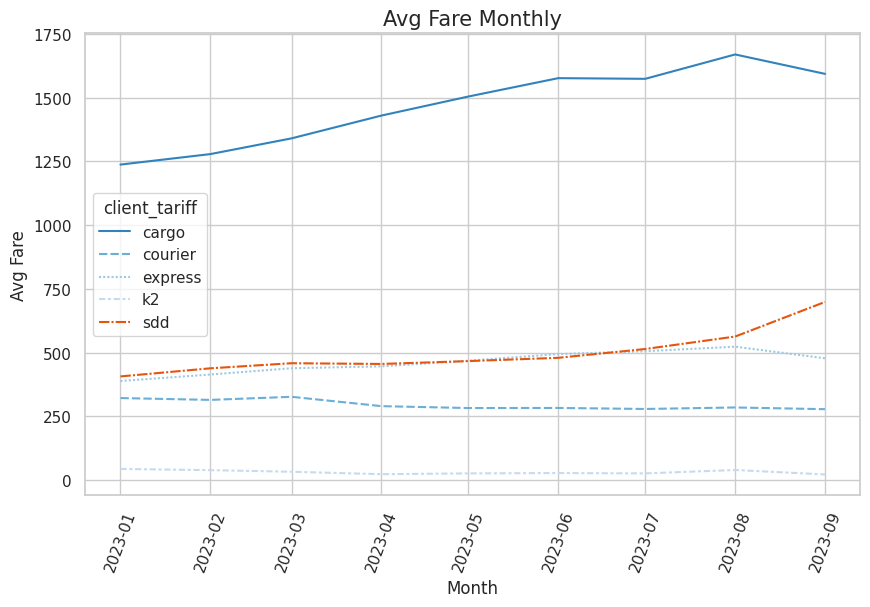

In [696]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=avg_fare_dt[['cargo', 'courier', 'express', 'k2', 'sdd']], palette='tab20c')
plt.xticks(rotation=70)

ax.set(xlabel="Month", ylabel="Avg Fare")
ax.set_title('Avg Fare Monthly', fontsize=15)
ax.figure.set_size_inches(10, 6)

# sns.despine(offset=10, trim=True)
# sns.set_context("notebook")

plt.show()

In [574]:
bov_financial_ru

,client_tariff,dt,gmv,net_inflow_lcy,deliveries,avg_fare
0,cargo,2023-01-01,5.954176e+08,8.029870e+07,480575.0,1238.969106
1,cargo,2023-02-01,6.787021e+08,9.305444e+07,530239.0,1279.992762
2,cargo,2023-03-01,8.735732e+08,1.266667e+08,651103.0,1341.681983
3,cargo,2023-04-01,9.620228e+08,1.420039e+08,672450.0,1430.623473
4,cargo,2023-05-01,1.081254e+09,1.884498e+08,718583.0,1504.703155
5,cargo,2023-06-01,1.179333e+09,2.051266e+08,747954.0,1576.745276
6,cargo,2023-07-01,1.237811e+09,2.111523e+08,786366.0,1574.089795
7,cargo,2023-08-01,1.417451e+09,2.549849e+08,848945.0,1669.661928
8,cargo,2023-09-01,9.338365e+08,1.585339e+08,585041.0,1596.189799
9,courier,2023-01-01,2.594260e+09,2.767914e+08,8051535.0,322.206841


In [602]:
ar_sql = '''
use hahn;

$sept_active_drivers = '//home/taxi-delivery/analytics/ghostrider/working/sept_active_drivers';
$fct_order_candidate = '//home/taxi-dwh/cdm/supply/fct_order_candidate/2023-09-01';

select taximeter_park_id, executor_profile_id,
           sum(case when oc.utc_seen_dttm is not null then 1 else 0 end) as offer_seen,
           sum(case when oc.utc_assigned_dttm is not null then 1 else 0 end) as offer_accepted
from $fct_order_candidate as oc
inner join $sept_active_drivers as ad on ad.taximeter_park_id = oc.park_taximeter_id
    and ad.executor_profile_id = oc.executor_profile_id
group by ad.taximeter_park_id as taximeter_park_id, ad.executor_profile_id as executor_profile_id
;
'''

In [603]:
ar_df = hahn(ar_sql)

In [604]:
ar_df

,taximeter_park_id,executor_profile_id,offer_seen,offer_accepted
0,7f3bcabd7c574545aa3a28ad69a5d834,00014c010d554d20b8644c37895797a2,2,2
1,d713d2921af64b9191dd24f3e70460fc,000ad9c7793762645ad1789fe261a693,10,7
2,4a42f9d48ea54f328f931832bcff506a,00163a20f30f4375b0f049c229f43b53,5,3
3,304db886277245c391a8f8e1bf6598f3,001ec907de484f3f8e0f098f118eb36e,10,10
4,20d789455c9d4bacb2d7b32954a04849,002a042ceb404bcc9eb02859692fbf1b,2,1
...,...,...,...,...
11820,0c29d41768e84038ba4950a0f3db97ac,fff27fbc8f9e40a8825b460aec230f1c,8,4
11821,c1dbbf636eba4b21b3782733bee76a0e,fff6f836c66f43ebbc89cf0235703140,41,26
11822,168b452ec9be4a6ba407cb0b440cd955,fff8108f3b6c499492803a85ff93c377,4,4
11823,761d6359e9c841f181dab62379a3e1d2,fffb195de5ef44ceb887990be5b98562,27,26


In [605]:
drivers_frequency

,deliveries,distinct_days,driver_net_inflow,effective_sh,executor_profile_id,is_fulltimer,mph,taximeter_park_id,total_sh,utilization,dbid_uuid,distinct_days_bucket
0,17,8,2062.82208,2.369444,74dbfa1e53d7fd0fb5b7c1cfa95a1173,0,596.334979,d60bb197c2eb4d19bb4c1f08dcd3aea6,3.459167,0.684976,d60bb197c2eb4d19bb4c1f08dcd3aea6_74dbfa1e53d7f...,0.2
1,10,7,1090.15000,1.258611,716ce9b3f5fa4f95b82b87d53d764f3f,0,382.061916,5206fcd893904fa092171a3e7bc8cfec,2.853333,0.441102,5206fcd893904fa092171a3e7bc8cfec_716ce9b3f5fa4...,0.2
2,6,1,7154.47684,10.371111,44b221042e6a497aa9e893a2e67ef584,0,587.931808,480dd7124eef4257bb2c648473cbaf36,12.168889,0.852264,480dd7124eef4257bb2c648473cbaf36_44b221042e6a4...,0.0
3,1,1,1047.23520,0.840833,f2ddcb125e524cfd97b57d1a1bc704bd,0,188.417548,cd3d31d43e784877904155e030ea453d,5.558056,0.151282,cd3d31d43e784877904155e030ea453d_f2ddcb125e524...,0.0
4,3,1,0.00000,2.578056,1a33e33de83045d895a8185b4ef89420,0,0.000000,fdfa5c13f65d46ee9c16c70f4695b77e,2.922500,0.882140,fdfa5c13f65d46ee9c16c70f4695b77e_1a33e33de8304...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11796,301,81,6384.36000,6.112222,da3690783edd42e6b3cf4ee2bb1d27c6,1,588.736802,21134b6b98e04a6dafd90e98d9d13c83,10.844167,0.563641,21134b6b98e04a6dafd90e98d9d13c83_da3690783edd4...,0.9
11797,203,73,53075.38228,52.803333,11be1964008e427f9a325c6f8a9a9305,1,561.395078,f66bebe3b5184a2c841991f2fe3f00aa,94.541944,0.558518,f66bebe3b5184a2c841991f2fe3f00aa_11be1964008e4...,0.8
11798,322,84,22244.36452,22.179722,25d935b992ec46a784fccebe02c8d7c2,1,525.178299,695bf6f6a7fb46b888bb69ce114a605d,42.355833,0.523652,695bf6f6a7fb46b888bb69ce114a605d_25d935b992ec4...,0.9
11799,206,61,76788.50220,58.935278,8fd8fb5cac45461c9d9c577601bf2bfb,1,1034.668563,6a757d94fd354135a2b779db8b8ef411,74.215556,0.794110,6a757d94fd354135a2b779db8b8ef411_8fd8fb5cac454...,0.8


In [607]:
drivers_frequency = drivers_frequency.merge(ar_df, how='left', on=['taximeter_park_id', 'executor_profile_id'])

In [608]:
drivers_frequency.columns

Index(['deliveries', 'distinct_days', 'driver_net_inflow', 'effective_sh',
       'executor_profile_id', 'is_fulltimer', 'mph', 'taximeter_park_id',
       'total_sh', 'utilization', 'dbid_uuid', 'distinct_days_bucket',
       'offer_seen', 'offer_accepted'],
      dtype='object')

In [615]:
drivers_frequency.isna().sum()

deliveries              0
distinct_days           0
driver_net_inflow       0
effective_sh            0
executor_profile_id     0
is_fulltimer            0
mph                     0
taximeter_park_id       0
total_sh                0
utilization             0
dbid_uuid               0
distinct_days_bucket    0
offer_seen              0
offer_accepted          0
dtype: int64